Extracting EDF parameters from /Users/alexnicorescu/Downloads/data.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Generated Events:
[[ 20250      0      1]
 [ 20500      0      1]
 [ 20750      0      1]
 [ 21000      0      1]
 [ 21250      0      1]
 [ 21500      0      1]
 [ 21750      0      1]
 [ 56250      0      2]
 [ 58750      0      2]
 [ 61250      0      2]
 [ 63750      0      2]
 [ 66250      0      2]
 [ 85000      0      1]
 [ 87500      0      1]
 [ 90000      0      1]
 [ 92500      0      1]
 [ 95000      0      1]
 [ 97500      0      1]
 [100000      0      1]
 [102500      0      1]
 [115000      0      2]
 [117500      0      2]
 [120000      0      2]
 [122500      0      2]
 [125000      0      2]
 [127500      0      2]
 [130000      0      2]]


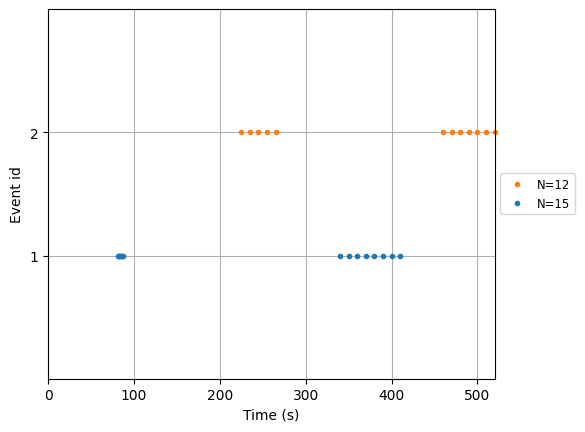

Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Loading data for 27 events and 2501 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Class distribution in the dataset:
1    15
2    12
Name: count, dtype: int64
Class distribution in the training set:
1    10
2     5
Name: count, dtype: int64
Class distribution in the test set:
2    7
1    5
Name: count, dtype: int64

Support Vector Machine Model:
Accuracy score: 0.4166666666666667
Confusion Matrix:
[[4 1]
 [6 1]]


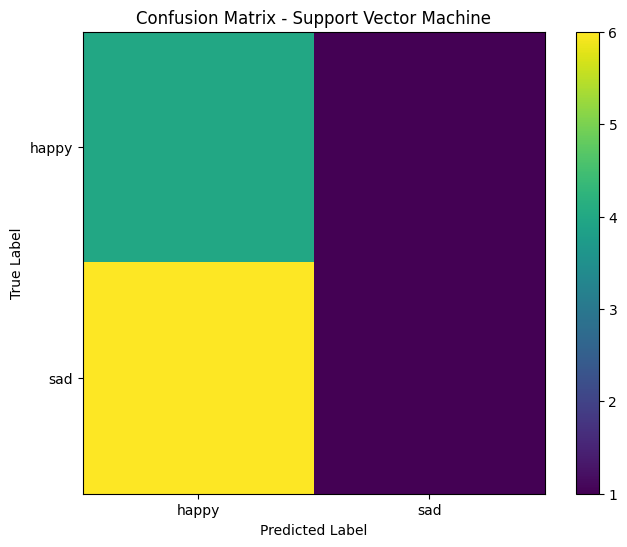


k-Nearest Neighbors Model:
Accuracy score: 0.3333333333333333
Confusion Matrix:
[[4 1]
 [7 0]]


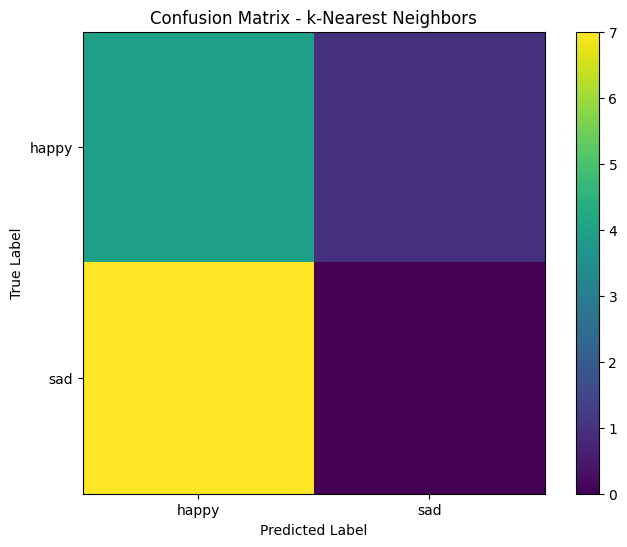


Gradient Boosting Model:
Accuracy score: 0.75
Confusion Matrix:
[[4 1]
 [2 5]]


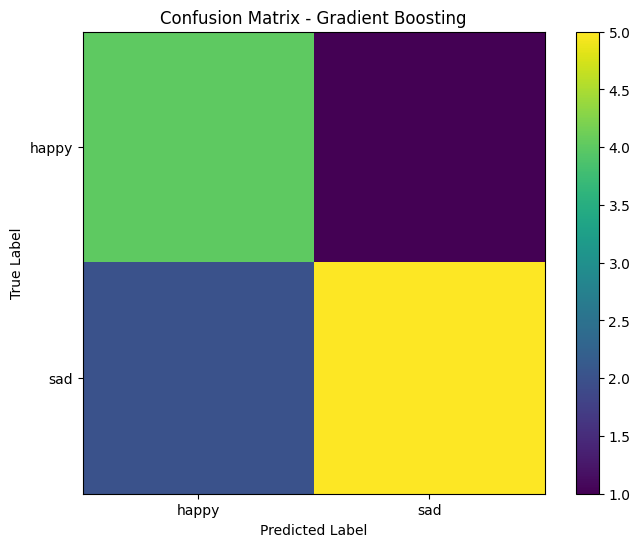

In [1]:
import mne
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/Users/alexnicorescu/Downloads/data.bdf")
raw.info["bads"].extend(['Accel X','Accel Y', 'Accel Z'])


annotations_df = pd.read_csv("/Users/alexnicorescu/Downloads/annotations4.csv")
annotations_df = annotations_df[annotations_df['description'] != 'ignore']
annotations_df['onset'] = annotations_df['onset'] / 1e9


emotional_states = {'happy': 1, 'sad': 2}


events = []
for index, row in annotations_df.iterrows():
    onset_sample = int(row['onset'] * raw.info['sfreq'])
    events.append([onset_sample, 0, emotional_states[row['description']]])

events = np.array(events)
print("Generated Events:")
print(events)

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


event_id = {'happy': 1, 'sad': 2}
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=10, baseline=None)


def eeg_power_band(epochs):
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)


X = eeg_power_band(epochs)
y = epochs.events[:, 2]

print("Class distribution in the dataset:")
print(pd.Series(y).value_counts())


split_idx = int(len(X) * 0.56)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Class distribution in the training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in the test set:")
print(pd.Series(y_test).value_counts())


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


models = {
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Model:")
    print(f"Accuracy score: {acc}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    plt.xticks([0, 1], ['happy', 'sad'])
    plt.yticks([0, 1], ['happy', 'sad'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
